In [1]:
%load_ext watermark


In [2]:
import os

import alifedata_phyloinformatics_convert as apc
from hstrat._auxiliary_lib import (
    alifestd_collapse_unifurcations,
    alifestd_downsample_tips_asexual,
    alifestd_downsample_tips_clade_asexual,
    alifestd_join_roots,
    alifestd_mark_leaves,
    alifestd_mark_origin_time_delta_asexual,
    alifestd_prune_extinct_lineages_asexual,
    alifestd_to_working_format,
    alifestd_try_add_ancestor_list_col,
)
import iplotx as ipx
from matplotlib import pyplot as plt
import polars as pl
from teeplot import teeplot as tp
from scipy import stats as scipy_stats


/usr/local/lib/python3.10/dist-packages/alifedata_phyloinformatics_convert/_impl/phytrack_Systematcs.py:7: UserWarning: ImportWarning: phylotrackpy.Systematics import failed; inserting a no-op mock for Systematics. This is likely because phylotrackpy is not installed.
  warnings.warn(


In [3]:
%watermark -diwmuv -iv


Last updated: 2026-02-13T13:32:18.940080+00:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.31.1

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 6.8.0-1044-azure
Machine     : x86_64
Processor   : x86_64
CPU cores   : 4
Architecture: 64bit

alifedata_phyloinformatics_convert: 0.19.3
iplotx                            : 1.7.0
scipy                             : 1.14.1
polars                            : 1.37.1
matplotlib                        : 3.10.0
teeplot                           : 1.4.2

Watermark: 2.4.3



In [4]:
teeplot_subdir = os.environ.get(
    "NOTEBOOK_NAME", "2026-02-12-billion-tip-phylos"
)
teeplot_subdir


'2026-02-12-billion-tip-phylos'

## Prep Data


In [5]:
phylo1_df = alifestd_try_add_ancestor_list_col(
    alifestd_mark_origin_time_delta_asexual(
        alifestd_to_working_format(
            alifestd_join_roots(
                pl.read_parquet("https://osf.io/download/485tx").to_pandas(),
            ),
        ),
    ),
)
phylo1_df


,id,dstream_data_id,ancestor_id,layer,position,globalSeed,nCol,nRow,nWav,nTrait,...,CEREBRASLIB_TRAITLOGGER_DSTREAM_ALGO_NAME,ASYNC_GA_GENOME_FLAVOR,data_hex,origin_time,hstrat_rank_from_t0,is_root,is_oldest_root,ancestor_origin_time,origin_time_delta,ancestor_list
0,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,None,NaN,NaN,True,True,NaN,NaN,[none]
1,1,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,None,NaN,NaN,False,False,NaN,NaN,[0]
2,2,9.223372e+18,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,None,262079.0,262079.0,False,False,NaN,NaN,[0]
3,3,9.223372e+18,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,None,393151.0,393151.0,False,False,262079.0,131072.0,[2]
4,4,9.223372e+18,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,None,458687.0,458687.0,False,False,393151.0,65536.0,[3]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99904,99904,9.992772e+08,99261,2499.0,160541.0,1.0,755.0,1170.0,5.0,1.0,...,steady_algo,genome_purifyingonly,bf7ffe4400123b6ab2c2d805f76e3a980e1d3dd0,1194793.0,1194793.0,False,False,1187887.0,6906.0,[99261]
99905,99905,9.992853e+08,95513,2499.0,168630.0,1.0,755.0,1170.0,5.0,1.0,...,steady_algo,genome_purifyingonly,bf7ffe4400123bcb15b22f7fb13bdcf7923938ba,1194890.0,1194890.0,False,False,1160639.0,34251.0,[95513]
99906,99906,9.996592e+08,94155,2499.0,542538.0,1.0,755.0,1170.0,5.0,1.0,...,steady_algo,genome_purifyingonly,bf7ffe4500123c8fae9449b9c67a57365fcbff2b,1195086.0,1195086.0,False,False,1159103.0,35983.0,[94155]
99907,99907,9.994994e+08,83917,2499.0,382743.0,1.0,755.0,1170.0,5.0,1.0,...,steady_algo,genome_purifyingonly,bf7ffe4400123d3f4a5f1550deb0d7da5fcbff2b,1195262.0,1195262.0,False,False,1105295.0,89967.0,[83917]


In [6]:
phylo2_df = alifestd_try_add_ancestor_list_col(
    alifestd_mark_origin_time_delta_asexual(
        alifestd_to_working_format(
            alifestd_join_roots(
                pl.read_parquet("https://osf.io/download/vkzdw").to_pandas(),
            ),
        ),
    )
)
phylo2_df


,id,dstream_data_id,ancestor_id,layer,position,globalSeed,nCol,nRow,nWav,nTrait,...,CEREBRASLIB_TRAITLOGGER_DSTREAM_ALGO_NAME,ASYNC_GA_GENOME_FLAVOR,data_hex,origin_time,hstrat_rank_from_t0,is_root,is_oldest_root,ancestor_origin_time,origin_time_delta,ancestor_list
0,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,None,NaN,NaN,True,True,NaN,NaN,[none]
1,1,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,None,NaN,NaN,False,False,NaN,NaN,[0]
2,2,9.223372e+18,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,None,262079.0,262079.0,False,False,NaN,NaN,[0]
3,3,9.223372e+18,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,None,393151.0,393151.0,False,False,262079.0,131072.0,[2]
4,4,9.223372e+18,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,None,458687.0,458687.0,False,False,393151.0,65536.0,[3]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99925,99925,9.997067e+08,96953,2499.0,590051.0,2.0,755.0,1170.0,5.0,1.0,...,steady_algo,genome_purifyingplus,bf7ffe1c0013f082e946554a438e0ebcbfba30e3,1306689.0,1306689.0,False,False,1281087.0,25602.0,[96953]
99926,99926,9.994150e+08,99292,2499.0,298307.0,2.0,755.0,1170.0,5.0,1.0,...,steady_algo,genome_purifyingplus,bf7ffe180013f0ca2a915b07740a47c98ebb527e,1306761.0,1306761.0,False,False,1298623.0,8138.0,[99292]
99927,99927,9.998592e+08,94803,2499.0,742514.0,2.0,755.0,1170.0,5.0,1.0,...,steady_algo,genome_purifyingplus,bf7ffe1e0013f1366c12edb6d7de8c1699dd1964,1306869.0,1306869.0,False,False,1267647.0,39222.0,[94803]
99928,99928,9.996051e+08,99880,2499.0,488465.0,2.0,755.0,1170.0,5.0,1.0,...,steady_algo,genome_purifyingplus,bf7ffe1c0013f1a7c9ed70d92f1050d66b5c440b,1306982.0,1306982.0,False,False,1304255.0,2727.0,[99880]


## Origin Time Stats


In [7]:
v1, v2 = map(
    float,
    (phylo1_df["origin_time"].mean(), phylo2_df["origin_time"].mean()),
)
v1, v2, v1 / v2


(922787.8430640496, 977858.2193679449, 0.9436826574516182)

In [8]:
v1, v2 = map(
    float,
    (phylo1_df["origin_time"].median(), phylo2_df["origin_time"].median()),
)
v1, v2, v1 / v2


(934591.0, 977845.5, 0.9557655069231284)

In [9]:
v1, v2 = map(
    float,
    (phylo1_df["origin_time"].max(), phylo2_df["origin_time"].max()),
)
v1, v2, v1 / v2


(1195285.0, 1307002.0, 0.9145242317915351)

In [10]:
v1, v2 = map(
    float,
    (phylo1_df["origin_time"].min(), phylo2_df["origin_time"].min()),
)
v1, v2, v1 / v2


(262079.0, 262079.0, 1.0)

In [11]:
scipy_stats.mannwhitneyu(
    phylo1_df["origin_time"].dropna(),
    phylo2_df["origin_time"].dropna(),
)


MannwhitneyuResult(statistic=np.float64(4141722201.5), pvalue=np.float64(0.0))

## Origin Time Delta Stats


In [12]:
phylo1_df["ot_delta"] = phylo1_df["origin_time_delta"]
phylo2_df["ot_delta"] = phylo2_df["origin_time_delta"]


In [13]:
v1, v2 = map(
    float,
    (phylo1_df["ot_delta"].mean(), phylo2_df["ot_delta"].mean()),
)
v1, v2, v1 / v2


(19480.658465542267, 14617.052148589957, 1.332735100587397)

In [14]:
v1, v2 = map(
    float,
    (phylo1_df["ot_delta"].median(), phylo2_df["ot_delta"].median()),
)
v1, v2, v1 / v2


(13659.0, 9344.0, 1.4617936643835616)

In [15]:
v1, v2 = map(
    float,
    (phylo1_df["ot_delta"].max(), phylo2_df["ot_delta"].max()),
)
v1, v2, v1 / v2


(239085.0, 239616.0, 0.9977839543269231)

In [16]:
v1, v2 = map(
    float,
    (phylo1_df["ot_delta"].min(), phylo2_df["ot_delta"].min()),
)
v1, v2


(1.0, 0.0)

In [17]:
scipy_stats.mannwhitneyu(
    phylo1_df["origin_time_delta"].dropna(),
    phylo2_df["origin_time_delta"].dropna(),
)


MannwhitneyuResult(statistic=np.float64(5881120161.0), pvalue=np.float64(0.0))

## Whole-tree Sample


In [18]:
tree1 = apc.RosettaTree(
    alifestd_downsample_tips_asexual(phylo1_df, 250, seed=1),
).as_dendropy
tree2 = apc.RosettaTree(
    alifestd_downsample_tips_asexual(phylo2_df, 250, seed=1),
).as_dendropy


teeplots/2026-02-12-billion-tip-phylos/layout=vertical+sample=down+viz=subplots+ext=.pdf
teeplots/2026-02-12-billion-tip-phylos/layout=vertical+sample=down+viz=subplots+ext=.png


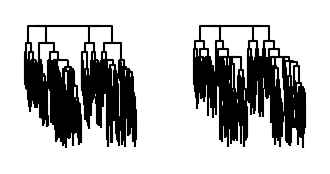

In [19]:
tree1.ladderize()
tree2.ladderize()

with tp.teed(
    plt.subplots,
    1,
    2,
    figsize=(4, 2),
    teeplot_outattrs={"layout": "vertical", "sample": "down"},
    teeplot_subdir=teeplot_subdir,
) as teed:
    fig, (ax1, ax2) = teed
    ipx.plotting.tree(
        tree1,
        ax=ax1,
        layout="vertical",
        edge_linewidth=1.5,
        margins=0.0,
    )
    ipx.plotting.tree(
        tree2,
        ax=ax2,
        layout="vertical",
        edge_linewidth=1.5,
        margins=0.0,
    )


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2026-02-12-billion-tip-phylos/layout=vertical+sample=down+viz=subplots+ext=.pdf, overwriting it
  warnings.warn(


teeplots/2026-02-12-billion-tip-phylos/layout=vertical+sample=down+viz=subplots+ext=.pdf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2026-02-12-billion-tip-phylos/layout=vertical+sample=down+viz=subplots+ext=.png, overwriting it
  warnings.warn(


teeplots/2026-02-12-billion-tip-phylos/layout=vertical+sample=down+viz=subplots+ext=.png


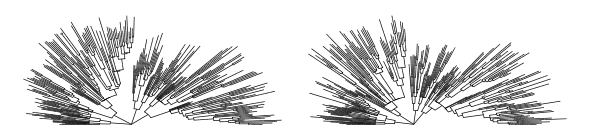

In [20]:
tree1.ladderize()
tree2.ladderize()

with tp.teed(
    plt.subplots,
    1,
    2,
    figsize=(6, 1.5),
    gridspec_kw={
        "wspace": 0.0,
        "hspace": 0.0,
    },
    teeplot_subdir=teeplot_subdir,
    teeplot_outattrs={"layout": "vertical", "sample": "down"},
) as teed:
    fig, (ax1, ax2) = teed

    style = [
        "tree",
        {
            "layout": {
                "start": -180,
                "span": 180,
            },
        },
    ]
    ipx.plotting.tree(
        tree1,
        ax=ax1,
        layout="radial",
        # layout_orientation="right",
        edge_linewidth=0.5,
        margins=-0.02,
        style=style,
    )
    ipx.plotting.tree(
        tree2,
        ax=ax2,
        angle=270,
        layout="radial",
        # layout_orientation="right",
        edge_linewidth=0.5,
        margins=-0.02,
        style=style,
    )
    fig.tight_layout()


## Clade Sample


In [21]:
tree1 = apc.RosettaTree(
    alifestd_downsample_tips_clade_asexual(phylo1_df, 4_000, seed=2),
).as_dendropy
tree2 = apc.RosettaTree(
    alifestd_downsample_tips_clade_asexual(phylo2_df, 4_000, seed=2),
).as_dendropy


teeplots/2026-02-12-billion-tip-phylos/layout=vertical+sample=clade+viz=subplots+ext=.pdf
teeplots/2026-02-12-billion-tip-phylos/layout=vertical+sample=clade+viz=subplots+ext=.png


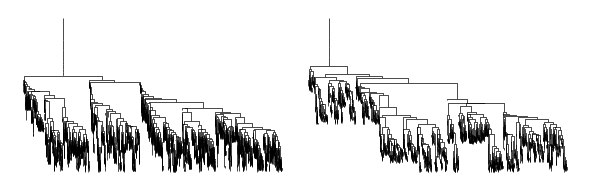

In [22]:
tree1.ladderize()
tree2.ladderize()

with tp.teed(
    plt.subplots,
    1,
    2,
    figsize=(6, 2),
    gridspec_kw={
        "wspace": 0.0,
        "hspace": 0.0,
    },
    teeplot_subdir=teeplot_subdir,
    teeplot_outattrs={"layout": "vertical", "sample": "clade"},
) as teed:
    fig, (ax1, ax2) = teed
    ipx.plotting.tree(
        tree1,
        ax=ax1,
        layout="vertical",
        edge_linewidth=0.5,
        margins=-0.02,
    )
    ipx.plotting.tree(
        tree2,
        ax=ax2,
        layout="vertical",
        edge_linewidth=0.5,
        margins=-0.02,
    )
    fig.tight_layout()


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2026-02-12-billion-tip-phylos/layout=vertical+sample=clade+viz=subplots+ext=.pdf, overwriting it
  warnings.warn(


teeplots/2026-02-12-billion-tip-phylos/layout=vertical+sample=clade+viz=subplots+ext=.pdf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2026-02-12-billion-tip-phylos/layout=vertical+sample=clade+viz=subplots+ext=.png, overwriting it
  warnings.warn(


teeplots/2026-02-12-billion-tip-phylos/layout=vertical+sample=clade+viz=subplots+ext=.png


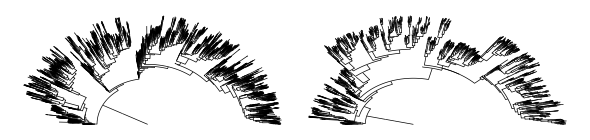

In [23]:
tree1.ladderize()
tree2.ladderize()

with tp.teed(
    plt.subplots,
    1,
    2,
    figsize=(6, 1.5),
    gridspec_kw={
        "wspace": 0.0,
        "hspace": 0.0,
    },
    teeplot_subdir=teeplot_subdir,
    teeplot_outattrs={"layout": "vertical", "sample": "clade"},
) as teed:
    fig, (ax1, ax2) = teed

    style = [
        "tree",
        {
            "layout": {
                "start": -180,
                "span": 180,
            },
        },
    ]
    ipx.plotting.tree(
        tree1,
        ax=ax1,
        layout="radial",
        # layout_orientation="right",
        edge_linewidth=0.5,
        margins=-0.02,
        style=style,
    )
    ipx.plotting.tree(
        tree2,
        ax=ax2,
        angle=270,
        layout="radial",
        # layout_orientation="right",
        edge_linewidth=0.5,
        margins=-0.02,
        style=style,
    )
    fig.tight_layout()


## Canopy Sample


In [24]:
phylo1_df = alifestd_mark_leaves(phylo1_df)
phylo2_df = alifestd_mark_leaves(phylo2_df)


In [25]:
n = 4_000
phylo1_df["extant"] = False
phylo1_df.loc[phylo1_df["is_leaf"], "extant"] = (
    phylo1_df.loc[phylo1_df["is_leaf"], "origin_time"].rank(
        ascending=False,
        method="first",
    )
    <= n
)
phylo2_df["extant"] = False
phylo2_df.loc[phylo2_df["is_leaf"], "extant"] = (
    phylo2_df.loc[phylo2_df["is_leaf"], "origin_time"].rank(
        ascending=False,
        method="first",
    )
    <= n
)

phylo1_df["extant"].sum(), phylo2_df["extant"].sum()


(np.int64(4000), np.int64(4000))

In [26]:
tree1 = apc.RosettaTree(
    # alifestd_mark_origin_time_delta_asexual(
    #     alifestd_collapse_unifurcations(
    alifestd_prune_extinct_lineages_asexual(phylo1_df),
    #     ),
    # ),
).as_dendropy
tree2 = apc.RosettaTree(
    # alifestd_mark_origin_time_delta_asexual(
    #     alifestd_collapse_unifurcations(
    alifestd_prune_extinct_lineages_asexual(phylo2_df),
    # ),
    # ),
).as_dendropy


teeplots/2026-02-12-billion-tip-phylos/layout=vertical+sample=canopy+viz=subplots+ext=.pdf
teeplots/2026-02-12-billion-tip-phylos/layout=vertical+sample=canopy+viz=subplots+ext=.png


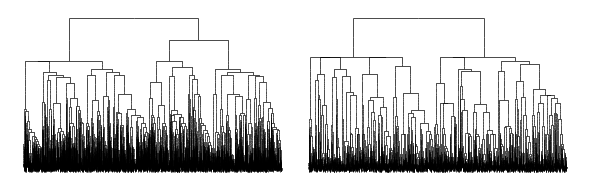

In [27]:
tree1.ladderize()
tree2.ladderize()

with tp.teed(
    plt.subplots,
    1,
    2,
    figsize=(6, 2),
    gridspec_kw={
        "wspace": 0.0,
        "hspace": 0.0,
    },
    teeplot_subdir=teeplot_subdir,
    teeplot_outattrs={"layout": "vertical", "sample": "canopy"},
) as teed:
    fig, (ax1, ax2) = teed
    ipx.plotting.tree(
        tree1,
        ax=ax1,
        layout="vertical",
        edge_linewidth=0.5,
        margins=-0.02,
    )
    ipx.plotting.tree(
        tree2,
        ax=ax2,
        layout="vertical",
        edge_linewidth=0.5,
        margins=-0.02,
    )
    fig.tight_layout()


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2026-02-12-billion-tip-phylos/layout=vertical+sample=canopy+viz=subplots+ext=.pdf, overwriting it
  warnings.warn(


teeplots/2026-02-12-billion-tip-phylos/layout=vertical+sample=canopy+viz=subplots+ext=.pdf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2026-02-12-billion-tip-phylos/layout=vertical+sample=canopy+viz=subplots+ext=.png, overwriting it
  warnings.warn(


teeplots/2026-02-12-billion-tip-phylos/layout=vertical+sample=canopy+viz=subplots+ext=.png


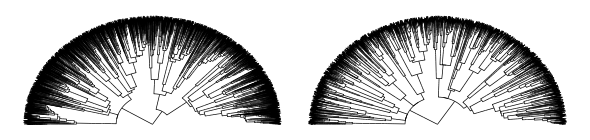

In [28]:
tree1.ladderize()
tree2.ladderize()

with tp.teed(
    plt.subplots,
    1,
    2,
    figsize=(6, 1.5),
    gridspec_kw={
        "wspace": 0.0,
        "hspace": 0.0,
    },
    teeplot_subdir=teeplot_subdir,
    teeplot_outattrs={"layout": "vertical", "sample": "canopy"},
) as teed:
    fig, (ax1, ax2) = teed

    style = [
        "tree",
        {
            "layout": {
                "start": -180,
                "span": 180,
            },
        },
    ]
    ipx.plotting.tree(
        tree1,
        ax=ax1,
        layout="radial",
        # layout_orientation="right",
        edge_linewidth=0.5,
        margins=-0.02,
        style=style,
    )
    ipx.plotting.tree(
        tree2,
        ax=ax2,
        angle=270,
        layout="radial",
        # layout_orientation="right",
        edge_linewidth=0.5,
        margins=-0.02,
        style=style,
    )
    fig.tight_layout()
